# Tucson's Dependency on Central Arizona Project (CAP) Water


In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
supply = pd.read_csv("Tucson_Supply.csv")
pop = pd.read_csv("Tucson_Population.csv")
supply.sort_values(by=["YEAR", "SECTOR"], inplace=True)
pop.sort_values(by=["YEAR"], inplace=True)

In [3]:
year = np.arange(1991, 2022)
sector = ["Industrial", "Agricultural", "Indian", "Municipal"]
supply_cap = supply.loc[
    supply["PARENT WATER TYPE OR SECTOR"].str.contains("CAP") == True
]

cap = np.full((year.shape[0], len(sector)), np.nan)

for i in range(year.shape[0]):
    for j in range(len(sector)):
        cap[i, j] = supply_cap.loc[
            (supply["YEAR"] == year[i]) & (supply["SECTOR"] == sector[j])
        ]["QUANTITY"].sum()
cap_sum = np.nansum(cap, axis=1)

mean_length = 12
cap_mean = np.mean(cap[-mean_length:, :], axis=0)
cap_mean_sum = np.mean(cap_sum[-mean_length:])

In [4]:
supply_gw = supply.loc[
    supply["PARENT WATER TYPE OR SECTOR"].str.contains("Groundwater") == True
]
supply_other = supply.loc[
    (supply["PARENT WATER TYPE OR SECTOR"].str.contains("CAP") == False)
    & (supply["PARENT WATER TYPE OR SECTOR"].str.contains("Groundwater") == False)
]
pop = pop.loc[(pop["BUDGET ELEMENT"].str.contains("Provider") == True)]


gw = np.full((year.shape[0]), np.nan)
other = np.full((year.shape[0]), np.nan)
population = np.full((year.shape[0]), np.nan)

for i in range(year.shape[0]):
    gw[i] = supply_gw.loc[supply["YEAR"] == year[i]]["QUANTITY"].sum()
    other[i] = supply_other.loc[supply["YEAR"] == year[i]]["QUANTITY"].sum()
    population[i] = pop.loc[pop["YEAR"] == year[i]]["QUANTITY"].sum()

gw_mean = np.mean(gw[-mean_length:])
other_mean = np.mean(other[-mean_length:])
supply_mean_sum = gw_mean + other_mean + cap_mean_sum

In [5]:
pop = pop.loc[(pop["BUDGET ELEMENT"].str.contains("Provider") == True)]
population = np.full((year.shape[0]), np.nan)
for i in range(year.shape[0]):
    population[i] = pop.loc[pop["YEAR"] == year[i]]["QUANTITY"].sum()

In [6]:
ama = gpd.read_file("AMA/AMA_and_INA.shp")
county = gpd.read_file("County/County_2020.shp")

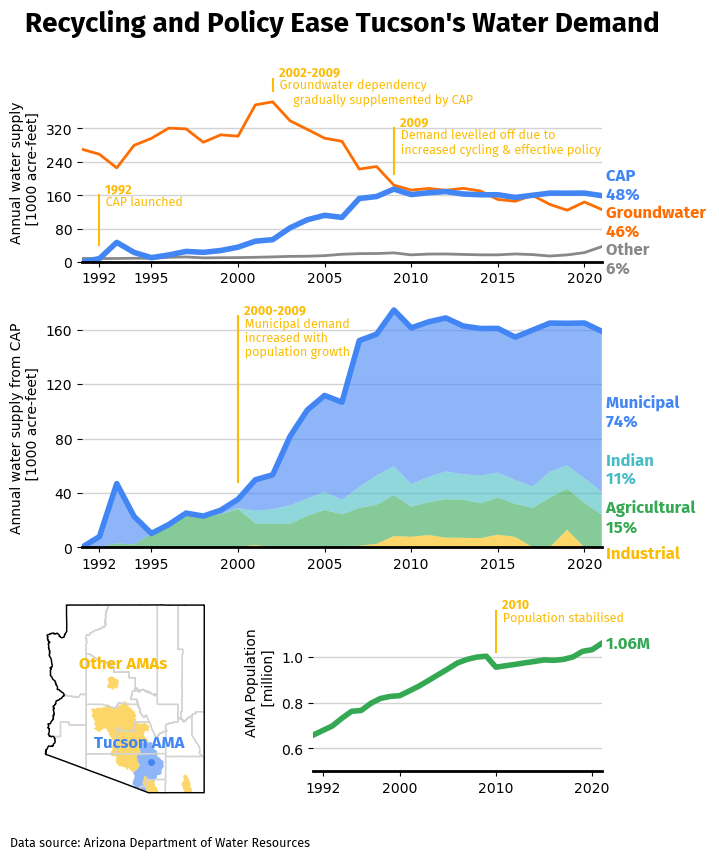

In [7]:
cm = 1 / 2.54
fig, axs = plt.subplot_mosaic(
    [["supply", "supply"], ["cap", "cap"], ["map", "population"]],
    figsize=(16.5 * cm, 22 * cm),
    gridspec_kw={"height_ratios": [3, 4, 3], "width_ratios": [1, 2]},
)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.2)

## Global settings
fsize = [9, 12]
subplots = ["cap", "population", "supply"]
lw_regular = 2
lw_bold = 4

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Fira Sans"

for subplot in subplots:
    axs[subplot].spines["top"].set_visible(False)
    axs[subplot].spines["right"].set_visible(False)
    axs[subplot].spines["left"].set_visible(False)
    axs[subplot].spines["bottom"].set_linewidth(2)
    axs[subplot].set(axisbelow=True)
    axs[subplot].grid(axis="y", color="lightgray", linewidth=1)

sector_colors = ["#fbbc04", "#34a853", "#46bdc6", "#4285f4"]

axs["cap"].stackplot(
    year,
    cap[:, 0] / 1000,
    cap[:, 1] / 1000,
    cap[:, 2] / 1000,
    cap[:, 3] / 1000,
    colors=sector_colors,
    alpha=0.6,
)
axs["cap"].plot(year, cap_sum / 1000, color=sector_colors[-1], linewidth=lw_bold)

bottom = 0
gap = 2
width = 2

mean_range = np.array([year[-mean_length], year[-1]])
mean_plot_range = np.array([year[-1] + gap, year[-1] + gap + width])

for n in range(len(sector)):
    mean = cap[-1, n] / 1000
    if cap[-1, n] > 0:
        legend_text = (
            " " + sector[n] + "\n " + "{:.0f}%".format(cap[-1, n] / cap_sum[-1] * 100)
        )
    else:
        legend_text = " " + sector[n]
    textshift = [-5, 10, 25, 0]
    axs["cap"].text(
        year[-1],
        bottom + mean / 2 + textshift[n],
        legend_text,
        va="center",
        color=sector_colors[n],
        fontweight="bold",
    )
    bottom += mean

for subplots in ["cap", "supply"]:
    axs[subplots].set_xlim(year[0], year[-1])
    axs[subplots].set_xticks(
        np.append(np.array([year[0] + 1], dtype=float), np.arange(1995, year[-1], 5))
    )
axs["cap"].set_ylim(0, 180)

axs["cap"].set_yticks(np.arange(0, 200, 40))

axs["cap"].set_ylabel("Annual water supply from CAP \n [1000 acre-feet]")

## Other subplots
xlim = [year[0], year[-1]]

means = np.array([gw_mean, other_mean, cap_mean_sum])
lws = np.array([lw_regular, lw_regular, lw_bold])


supply_colors = ["#ff6d01", "#888888"]

axs["supply"].plot(year, gw / 1000, linewidth=lw_regular, color=supply_colors[0])
axs["supply"].plot(year, other / 1000, linewidth=lw_regular, color=supply_colors[1])
axs["supply"].plot(year, cap_sum / 1000, linewidth=lw_bold, color=sector_colors[3])

axs["supply"].text(
    year[-1],
    gw[-1] / 1000 - 30,
    " Groundwater \n " + "{:.0f}%".format(gw_mean / supply_mean_sum * 100),
    va="center",
    fontweight="bold",
    color=supply_colors[0],
)
axs["supply"].text(
    year[-1],
    other[-1] / 1000 - 30,
    " Other \n " + "{:.0f}%".format(other_mean / supply_mean_sum * 100),
    va="center",
    fontweight="bold",
    color=supply_colors[1],
)
axs["supply"].text(
    year[-1],
    cap_sum[-1] / 1000 + 25,
    " CAP \n " + "{:.0f}%".format(cap_mean_sum / supply_mean_sum * 100),
    va="center",
    fontweight="bold",
    color=sector_colors[3],
)

axs["supply"].set_yticks(np.arange(0, 400, 80))
axs["supply"].set_ylim(0, 440)
axs["supply"].set_ylabel("Annual water supply \n [1000 acre-feet]")

axs["population"].plot(
    year, population / 1e6, linewidth=lw_bold, color=sector_colors[1]
)

axs["population"].text(
    year[-1],
    population[-1] / 1e6,
    " {:.2f}M".format(population[-1] / 1e6),
    va="center",
    color=sector_colors[1],
    fontweight="bold",
)

axs["population"].set_xticks([1992, 2000, 2010, 2020])
axs["population"].set_yticks([0.6, 0.8, 1.0])
axs["population"].set_ylim(0.5, 1.3)
axs["population"].set_xlim(xlim)
axs["population"].set_ylabel("AMA Population \n [million]")

county.boundary.plot(ax=axs["map"], color="lightgray", linewidth=lw_regular / 2)
county_outline = county.unary_union
county_outline = gpd.GeoDataFrame(geometry=[county_outline])
county_outline.boundary.plot(ax=axs["map"], color="black", linewidth=lw_regular / 2)
ama.plot(
    ax=axs["map"],
    color=[
        sector_colors[0],
        "w",
        "w",
        sector_colors[0],
        sector_colors[0],
        "w",
        sector_colors[0],
        sector_colors[-1],
        "w",
        sector_colors[0],
    ],
    alpha=0.6,
)


axs["map"].plot(-110.9742, 32.2540, "o", color=sector_colors[-1], markersize=lw_bold)
axs["map"].text(
    -110.9742,
    32.6,
    "Tucson AMA      ",
    va="bottom",
    ha="center",
    color=sector_colors[-1],
    fontweight="bold",
)
axs["map"].text(
    -112,
    35,
    "Other AMAs",
    va="bottom",
    ha="center",
    color=sector_colors[0],
    fontweight="bold",
)

axs["map"].axis("off")
axs["map"].set_xlim(-114.9, -109)
axs["map"].set_ylim(31.3, 37.1)

plt.annotate(
    "Data source: Arizona Department of Water Resources",
    (10, 10),
    xycoords="figure pixels",
    ha="left",
    va="bottom",
    size=9,
)

axs["map"].set_position([0.04, 0.06, 0.25, 0.25])


def add_annotation(ax, x, y, year, text, colour, size):
    ax.plot([x, x], y, linewidth=lw_regular * 3 / 4, color=colour)
    ax.text(
        x,
        y[1],
        "  " + year,
        va="bottom",
        ha="left",
        color=colour,
        fontweight="bold",
        size=size,
    )
    ax.text(
        x,
        y[1],
        text,
        va="top",
        ha="left",
        color=colour,
        size=size,
    )


annotation_color = sector_colors[0]
annotation_size = 9
add_annotation(
    axs["supply"],
    2009,
    [210, 320],
    "2009",
    "  Demand levelled off due to  \n  increased cycling & effective policy",
    annotation_color,
    annotation_size,
)
add_annotation(
    axs["supply"],
    2002,
    [410, 440],
    "2002-2009",
    "  Groundwater dependency \n      gradually supplemented by CAP",
    annotation_color,
    annotation_size,
)
add_annotation(
    axs["supply"],
    1992,
    [40, 160],
    "1992",
    "  CAP launched",
    annotation_color,
    annotation_size,
)
add_annotation(
    axs["cap"],
    2000,
    [48, 170],
    "2000-2009",
    "  Municipal demand \n  increased with \n  population growth",
    annotation_color,
    annotation_size,
)
add_annotation(
    axs["population"],
    2010,
    [1.02, 1.2],
    "2010",
    "  Population stabilised",
    annotation_color,
    annotation_size,
)

fig.suptitle(
    "Recycling and Policy Ease Tucson's Water Demand", fontsize=20, fontweight="bold"
)

plt.savefig("QAR-Analysis.png", dpi=600, bbox_inches="tight")
plt.show()